# [실습4] 최적의 인공지능 성능 및 유도 및 기계설비 예지보전 정확도 향상을 위한 과정의 이해
----

## 실습 목차
---
1. ML을 이용한 기계설비 이상 진단 여부 예측 모델 정확도 향상 과정 실습
1. DL을 이용한 기계설비 이상 진단 여부 예측 모델 정확도 향상 과정 실습

## 실습 개요
---
다양한 인공지능 기법을 활용하여 최적의 성능을 갖는 인공지능 모델을 구현하고 하이퍼파라미터 튜닝 등 다양한 기법을 통해 인공지능 모델의 성능을 향상할 수 있도록 합니다.

---

### 라이브러리 불러오기
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **sklearn**: 머신러닝을 다루기 위한 라이브러리
 - **operator**: 표준 연산자를 다루기 위한 라이브러리
 - **functools**: 고차 함수와 콜러블 객체에 대한 연산을 다루기 위한 라이브러리
 - **lightgbm**: LightGBM을 다루기 위한 라이브러리
 - **tensorflow**: 딥러닝을 다루기 위한 라이브러리
 - **tqdm**: 진행상황을 확인하기 위한 라이브러리
 - **warrings**: 경고 메시지를 다루기 위한 라이브러리

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from operator import add
from functools import reduce


from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, backend

from tqdm import tqdm
import warnings

2023-08-23 08:41:17.809112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 08:41:18.035795: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 08:41:21.548660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-23 08:41:21.548845: W tensorflow/

## 1. ML을 이용한 기계설비 이상 진단 여부 예측 모델 정확도 향상 과정 실습
---


### 1.1 ML 모델 적용을 위한 데이터 로드 및 전처리

pandas를 사용하여 dataframe 형태로 motor_signals를 불러와 `signals_df`에 저장합니다.

pandas를 사용하여 dataframe 형태로 motor_classes를 불러와 `classes_df`에 저장합니다. 불러 올 때 parameter는 `sep=";"`로 설정합니다.

In [2]:
# motor_signals.csv 불러오기
signals_df = pd.read_csv("./data/motor_signals.csv")

# motor_classes.csv 불러오기
classes_df = pd.read_csv("./data/motor_classes.csv", sep=";")

In [3]:
classes_df.head()

,bearing_id,status
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [4]:
signals_df.head()

,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006
1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243
2,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369
3,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520
4,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175


In [5]:
df = signals_df.merge(classes_df, left_on="bearing_2_id", right_on="bearing_id").drop(columns=["bearing_id"])

In [6]:
df.head()

,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w,status
0,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006,0
1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243,0
2,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369,0
3,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520,0
4,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175,0


In [7]:
df.columns

Index(['bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x', 'a1_y', 'a1_z',
       'a2_x', 'a2_y', 'a2_z', 'rpm', 'hz', 'w', 'status'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6710700 entries, 0 to 6710699
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   bearing_1_id  int64  
 1   bearing_2_id  int64  
 2   timestamp     float64
 3   a1_x          float64
 4   a1_y          float64
 5   a1_z          float64
 6   a2_x          float64
 7   a2_y          float64
 8   a2_z          float64
 9   rpm           float64
 10  hz            float64
 11  w             float64
 12  status        int64  
dtypes: float64(10), int64(3)
memory usage: 716.8 MB


전처리 전 rpm, hz 컬럼은 제외한 각 컬럼의 histogram을 확인합니다.

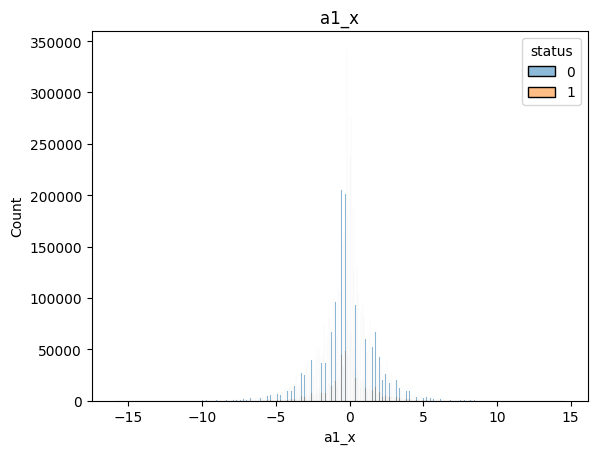

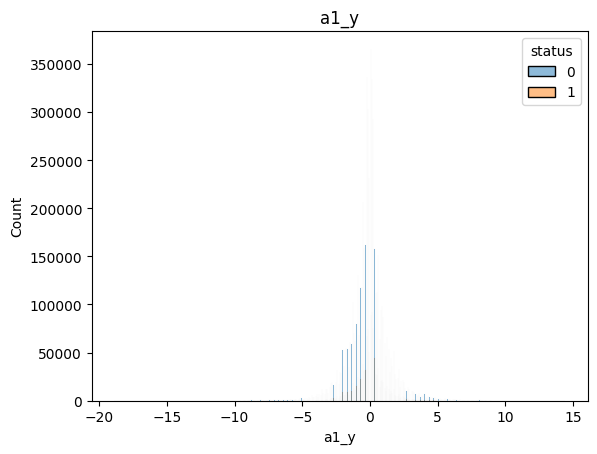

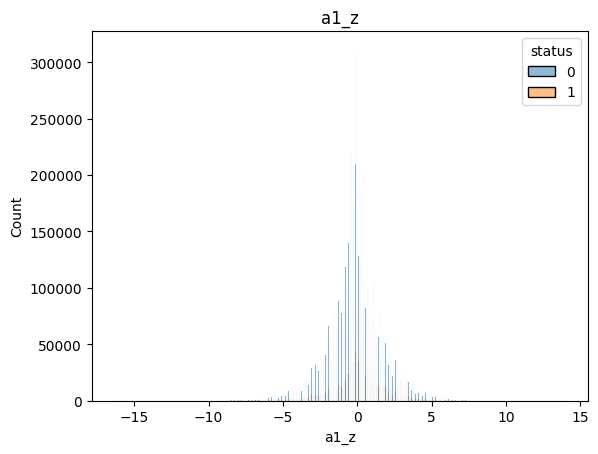

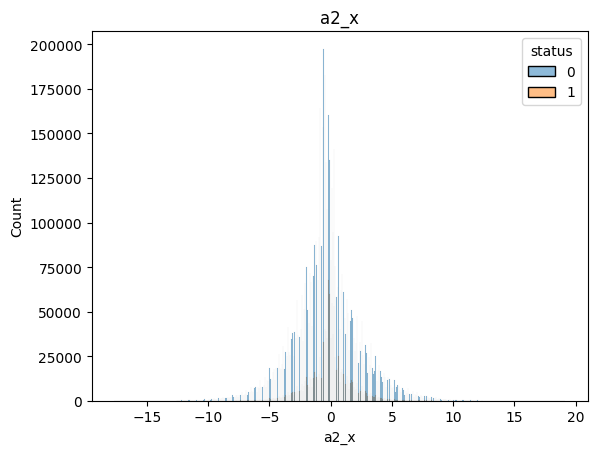

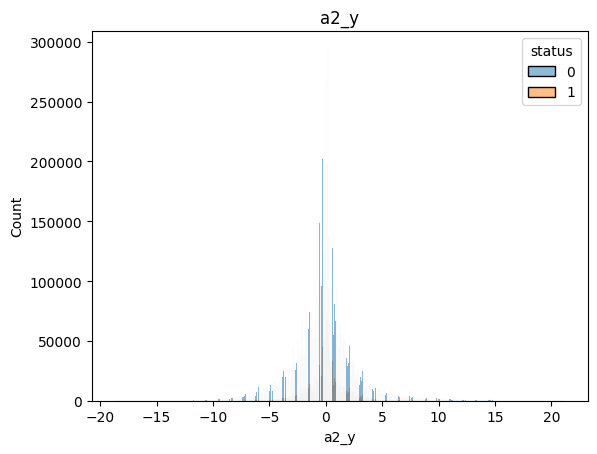

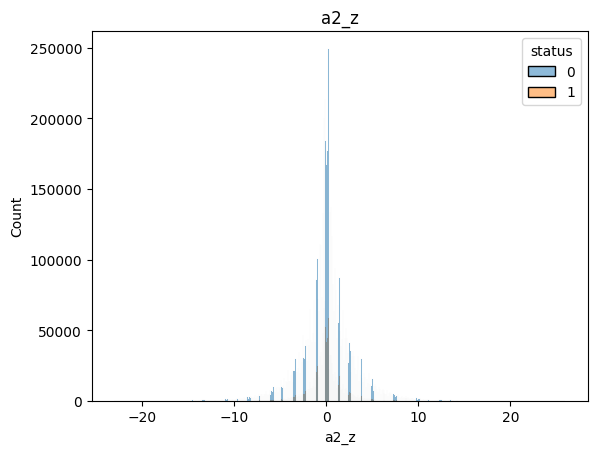

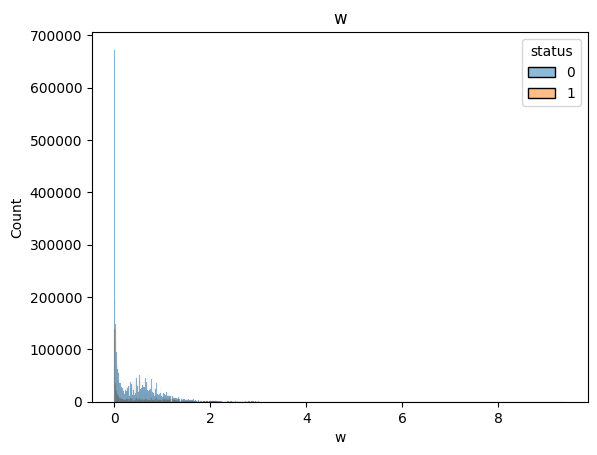

In [9]:
for col in df.columns[3:-4].to_list() + ["w"]:
    sns.histplot(
        data = df,
        x = col,
        hue="status"
    )
    plt.title(col)
    plt.show()

- 데이터가 정제되지 않아 시각화를 통해서도 어떠한 인사이트를 찾기엔 힘들어 보입니다.

In [10]:
classes_df

,bearing_id,status
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
68,68,1
69,69,1
70,70,1
71,71,1


In [11]:
classes_df.status.value_counts()

0    60
1    13
Name: status, dtype: int64

`signals_df`의 `timestamp`를 데이터 분석 및 전처리 시에 편의성을 높이기 위해 round를 적용합니다.

In [12]:
signals_df.timestamp = signals_df.timestamp.round(1)

In [13]:
signals_df

,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,0,1,0.0,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.000000,0.000000,0.000006
1,0,1,0.0,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.000000,0.000000,0.000243
2,0,1,0.0,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.000000,0.000000,0.000369
3,0,1,0.0,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.000000,0.000000,0.000520
4,0,1,0.0,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.000000,0.000000,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...
6710695,0,72,32.1,-0.367713,0.149706,0.465916,-0.469243,0.194450,0.553945,178.748759,2.979146,0.019412
6710696,0,72,32.1,-0.463909,0.338975,0.561948,-0.469243,0.194450,0.354653,178.748759,2.979146,0.032027
6710697,0,72,32.1,0.017072,0.433610,0.369884,-0.563647,-0.093886,0.155361,178.748759,2.979146,0.012211
6710698,0,72,32.1,0.209465,0.244341,0.273852,-0.374838,0.194450,0.155361,178.748759,2.979146,0.000764


`bearing_2_id`, `timstamp의` group별로 mean, std, min, max, 25%, 50%, 75% 값을 구합니다.

하나의 `bearing_2_id`는 여러개의 `timestamp`를 갖고 있으며, 하나의 timestamp는 여러 row를 가지고 있습니다.

`timestamp`별로 row의 통계치를 추출하여 `timestamp`별로 하나의 row만을 가지도록 합니다.

**주의!! 5~10분 걸릴 수 있음**

In [14]:
# 통계데이터를 담을 values와 key를 담을 keys를 list로 선언합니다.
values = []
keys = []

# for를 이용하여 signals_df의 bearing_2_id 컬럼에서 unique한 값만 가져와 id에 저장합니다.
for id in tqdm(signals_df.bearing_2_id.unique()):
    # for를 이용하여 signals_df의 bearing_2_id이 id와 일치하는 timestamp 컬럼에서 unique한 값만 가져와 t에 저장합니다.
    for t in signals_df[signals_df.bearing_2_id==id].timestamp.unique():
        # [id, t]를 keys에 append 합니다.
        keys.append([id, t])
        # signals_df에서 bearing_2_id와 id, timetamp와 t가 동시에 일치하는 dataframe만 가져와 저장합니다.
        value_df = signals_df[(signals_df.bearing_2_id==id) & (signals_df.timestamp==t)]
        # 가져온 dataframe 중 bearing_1_id, bearing_2_id, timestamp은 제외합니다.
        value_df = value_df.iloc[:, 3:]
        # describe를 이용하여 기본적인 통계값을 구합니다. 이 때 count 값은 제외합니다.
        value_df = value_df.describe()[1:]
        # value_df를 1개의 row로 변환합니다.
        value_df = value_df.stack().to_frame().T
        # value_df를 values에 append 합니다.
        values.append(value_df)

100%|██████████| 72/72 [08:29<00:00,  7.07s/it]


In [15]:
values_df = pd.concat(values)

컬럼명을 agg_col 형태로 변환합니다. 예) mean_a1_x, mean_a1_y ... max_hz, max_w

list comprehension을 이용하여 `values_df.columns`를 agg, col로 가져 온 후 agg_col 형태로 `values_df.columns`에 다시 저장합니다.

In [16]:
values_df.columns = [f"{agg}_{col}" for agg, col in values_df.columns]
values_df.reset_index(drop=True, inplace=True)

`keys`를 DataFrame으로 변환하여 `keys_df`에 저장합니다.

In [17]:
keys_df = pd.DataFrame(keys, columns=signals_df.columns[1:3])

`keys_df`와 `values_df`를 concat하여 `bearing_2_id`, `timestamp` 별로 통계값을 가진 데이터프레임을 완성합니다.

In [18]:
seq_df = pd.concat([keys_df, values_df], axis=1)

# seq_df를 출력합니다.
seq_df

,bearing_2_id,timestamp,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,...,75%_w,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w
0,1,0.0,-0.096325,0.016842,-0.112183,0.144073,0.048054,0.199575,0.000000,0.000000,...,0.000520,0.209465,0.528244,0.369884,0.474800,0.290562,0.553945,0.000000,0.000000,0.000901
1,1,0.1,-0.091028,0.016458,-0.105779,0.151489,0.038228,0.192020,0.000000,0.000000,...,0.000520,0.305661,0.528244,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.000976
2,1,0.2,-0.092547,0.013571,-0.110275,0.151442,0.037989,0.193432,0.000000,0.000000,...,0.000520,0.209465,0.433610,0.273852,0.380396,0.386674,0.553945,0.000000,0.000000,0.000976
3,1,0.3,-0.083628,0.012977,-0.101925,0.148332,0.028263,0.190687,0.000000,0.000000,...,0.000520,0.305661,0.338975,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.002084
4,1,0.4,-0.088712,0.020488,-0.121761,0.137642,0.031922,0.187804,0.000000,0.000000,...,0.000520,0.401857,0.433610,0.273852,0.474800,0.290562,0.553945,0.000000,0.000000,0.001130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22436,72,31.7,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,...,0.017456,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170
22437,72,31.8,-0.071108,0.083462,0.110918,-0.131905,0.141909,0.147058,182.555781,3.042596,...,0.017456,0.690446,0.717513,0.850044,0.852418,0.867233,1.749695,182.555781,3.042596,0.237735
22438,72,31.9,-0.056358,0.100181,0.124363,-0.137883,0.123327,0.074980,182.555781,3.042596,...,0.017456,0.786643,1.001417,0.754012,0.758013,0.963345,1.749695,182.555781,3.042596,0.099774
22439,72,32.0,-0.071428,0.077153,0.138768,-0.132219,0.134540,0.191234,181.933967,3.032233,...,0.020429,0.786643,0.812148,0.754012,0.852418,1.347793,4.141196,182.555781,3.042596,0.106719


`seq_df`와 `classes_df`를 merge하여 `result_df`에 저장합니다.

In [19]:
result_df = seq_df.merge(classes_df, left_on="bearing_2_id", right_on="bearing_id").drop(columns=["bearing_id"])
result_df

,bearing_2_id,timestamp,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,...,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w,status
0,1,0.0,-0.096325,0.016842,-0.112183,0.144073,0.048054,0.199575,0.000000,0.000000,...,0.209465,0.528244,0.369884,0.474800,0.290562,0.553945,0.000000,0.000000,0.000901,0
1,1,0.1,-0.091028,0.016458,-0.105779,0.151489,0.038228,0.192020,0.000000,0.000000,...,0.305661,0.528244,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.000976,0
2,1,0.2,-0.092547,0.013571,-0.110275,0.151442,0.037989,0.193432,0.000000,0.000000,...,0.209465,0.433610,0.273852,0.380396,0.386674,0.553945,0.000000,0.000000,0.000976,0
3,1,0.3,-0.083628,0.012977,-0.101925,0.148332,0.028263,0.190687,0.000000,0.000000,...,0.305661,0.338975,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.002084,0
4,1,0.4,-0.088712,0.020488,-0.121761,0.137642,0.031922,0.187804,0.000000,0.000000,...,0.401857,0.433610,0.273852,0.474800,0.290562,0.553945,0.000000,0.000000,0.001130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22436,72,31.7,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,...,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170,1
22437,72,31.8,-0.071108,0.083462,0.110918,-0.131905,0.141909,0.147058,182.555781,3.042596,...,0.690446,0.717513,0.850044,0.852418,0.867233,1.749695,182.555781,3.042596,0.237735,1
22438,72,31.9,-0.056358,0.100181,0.124363,-0.137883,0.123327,0.074980,182.555781,3.042596,...,0.786643,1.001417,0.754012,0.758013,0.963345,1.749695,182.555781,3.042596,0.099774,1
22439,72,32.0,-0.071428,0.077153,0.138768,-0.132219,0.134540,0.191234,181.933967,3.032233,...,0.786643,0.812148,0.754012,0.852418,1.347793,4.141196,182.555781,3.042596,0.106719,1


In [20]:
result_df.columns

Index(['bearing_2_id', 'timestamp', 'mean_a1_x', 'mean_a1_y', 'mean_a1_z',
       'mean_a2_x', 'mean_a2_y', 'mean_a2_z', 'mean_rpm', 'mean_hz', 'mean_w',
       'std_a1_x', 'std_a1_y', 'std_a1_z', 'std_a2_x', 'std_a2_y', 'std_a2_z',
       'std_rpm', 'std_hz', 'std_w', 'min_a1_x', 'min_a1_y', 'min_a1_z',
       'min_a2_x', 'min_a2_y', 'min_a2_z', 'min_rpm', 'min_hz', 'min_w',
       '25%_a1_x', '25%_a1_y', '25%_a1_z', '25%_a2_x', '25%_a2_y', '25%_a2_z',
       '25%_rpm', '25%_hz', '25%_w', '50%_a1_x', '50%_a1_y', '50%_a1_z',
       '50%_a2_x', '50%_a2_y', '50%_a2_z', '50%_rpm', '50%_hz', '50%_w',
       '75%_a1_x', '75%_a1_y', '75%_a1_z', '75%_a2_x', '75%_a2_y', '75%_a2_z',
       '75%_rpm', '75%_hz', '75%_w', 'max_a1_x', 'max_a1_y', 'max_a1_z',
       'max_a2_x', 'max_a2_y', 'max_a2_z', 'max_rpm', 'max_hz', 'max_w',
       'status'],
      dtype='object')

rpm, hz 컬럼은 제외한 각 컬럼의 histogram을 확인합니다.

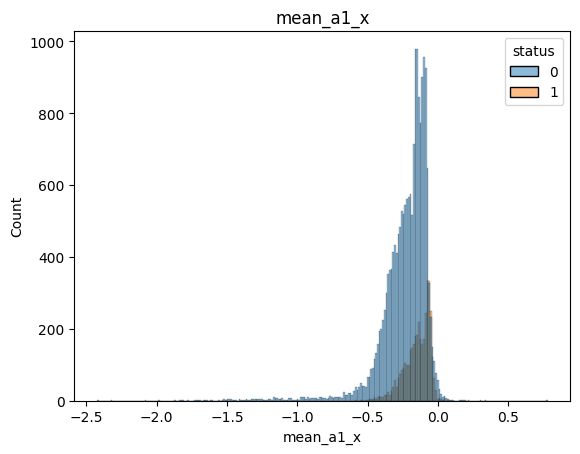

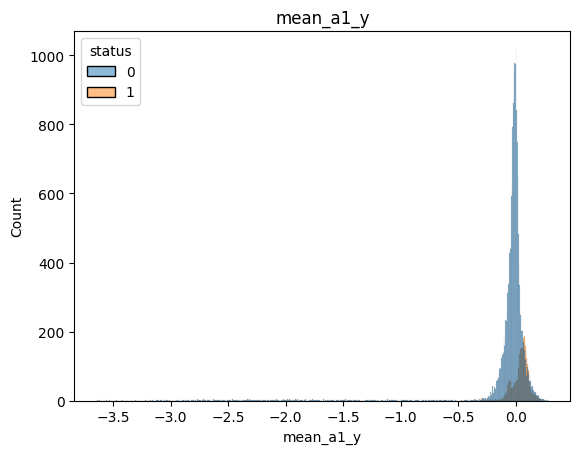

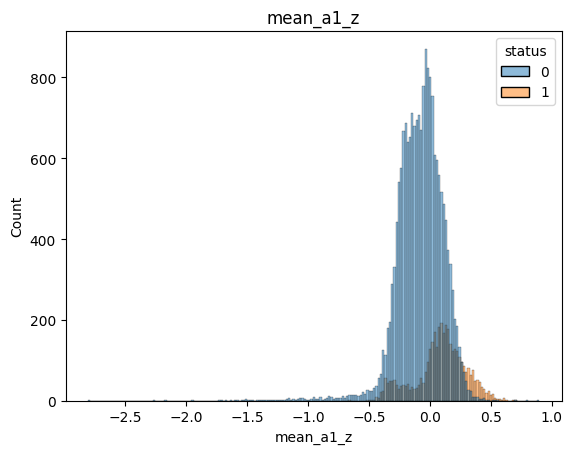

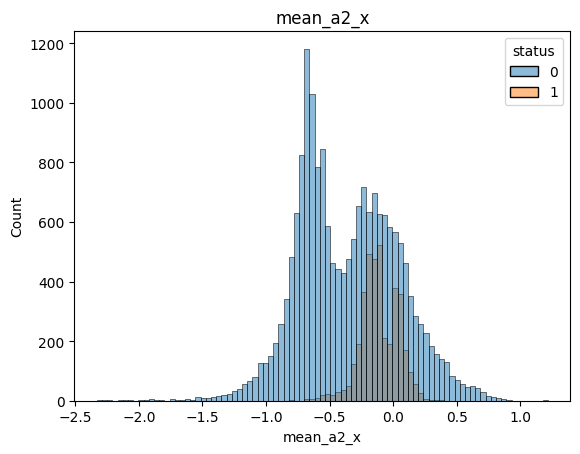

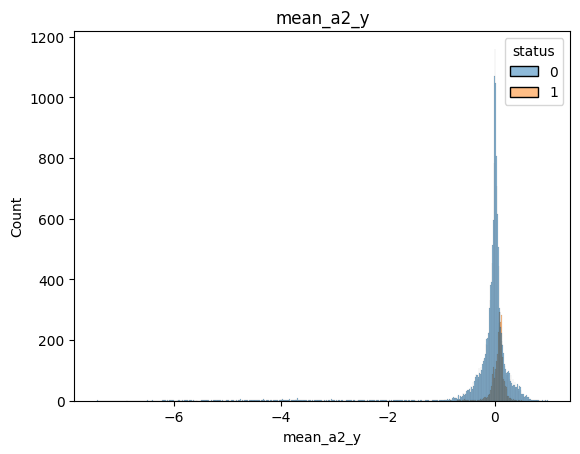

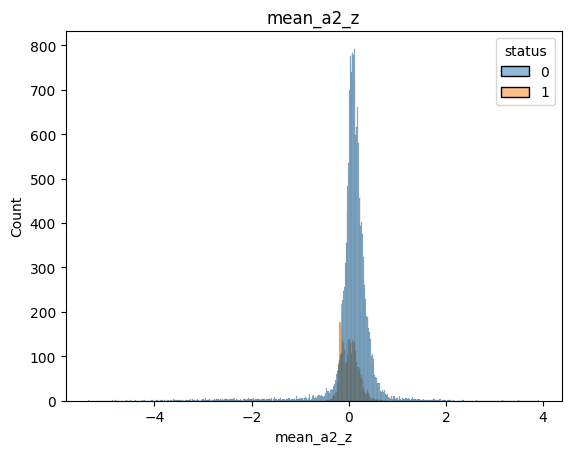

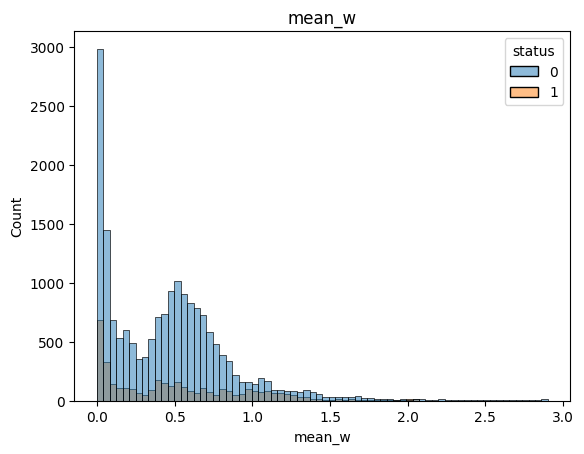

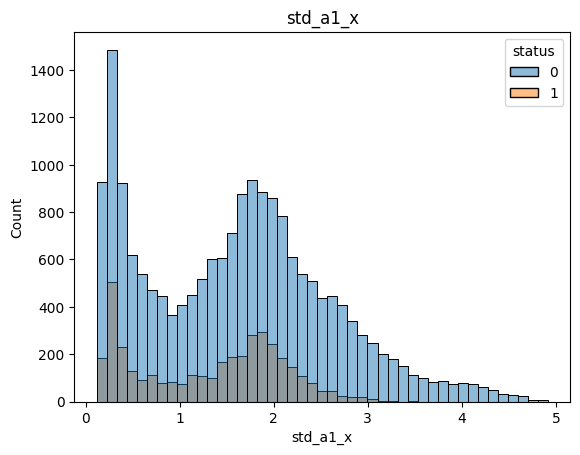

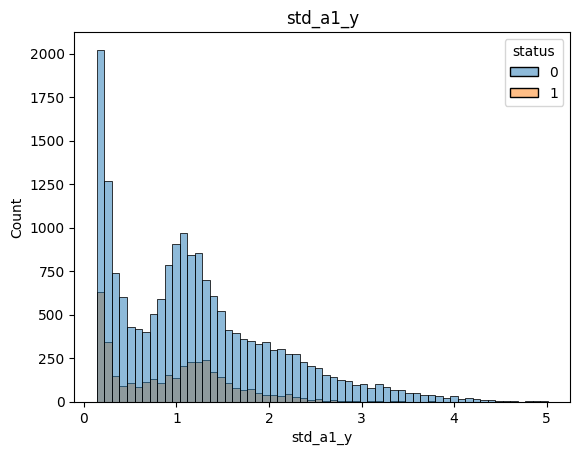

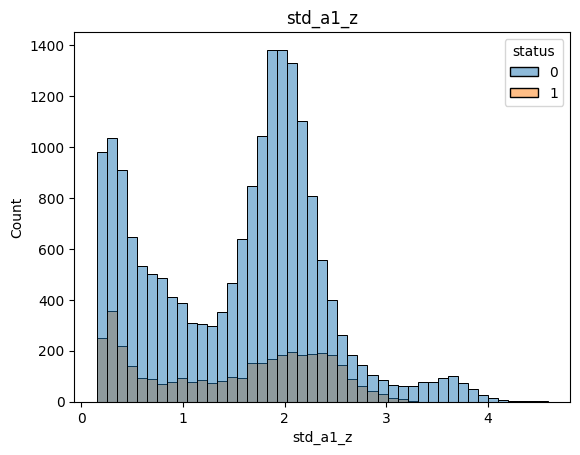

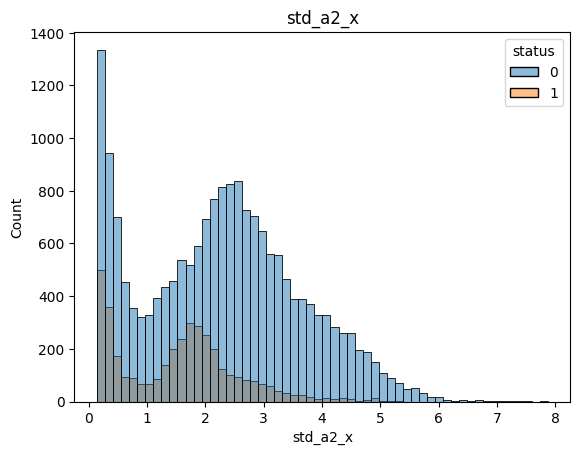

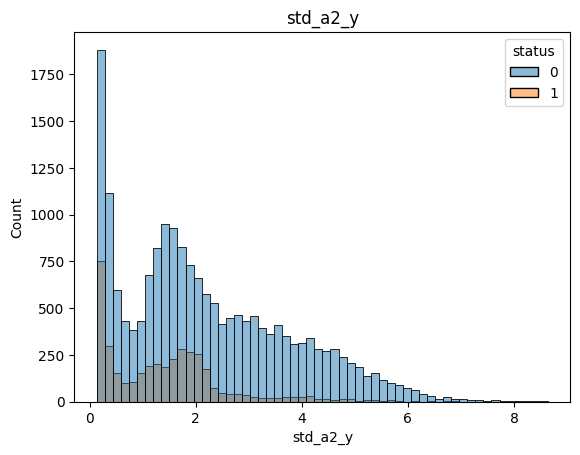

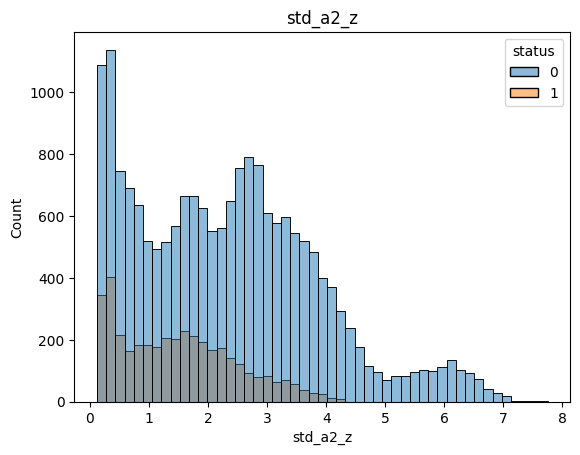

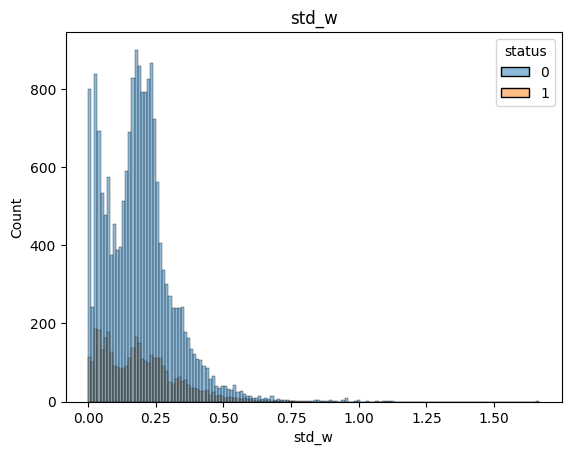

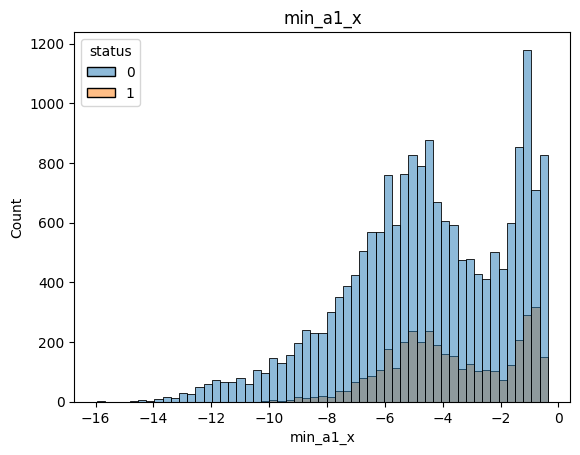

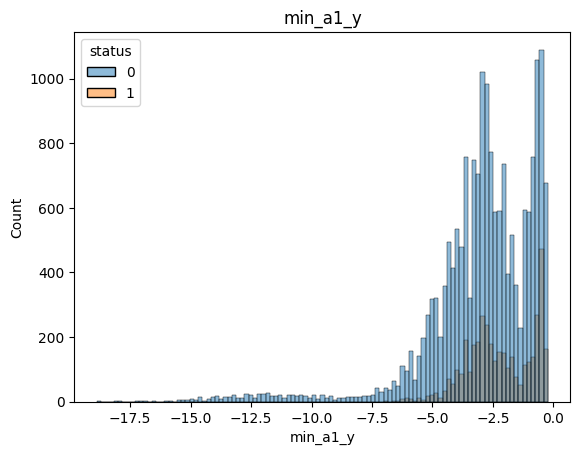

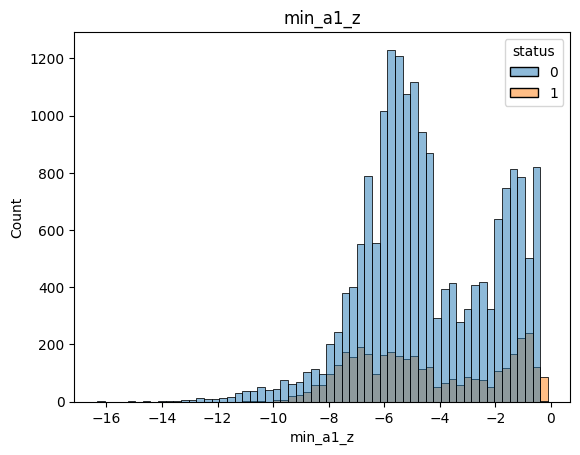

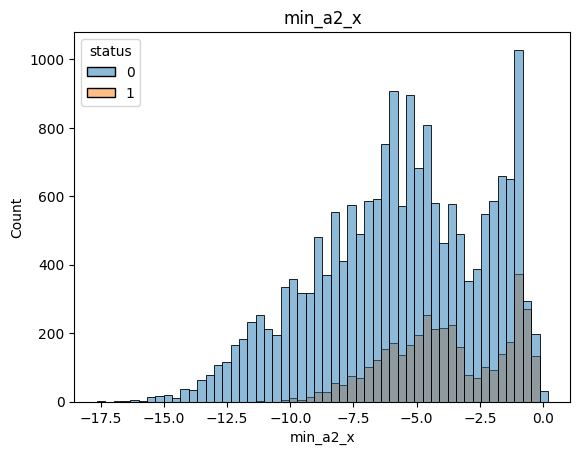

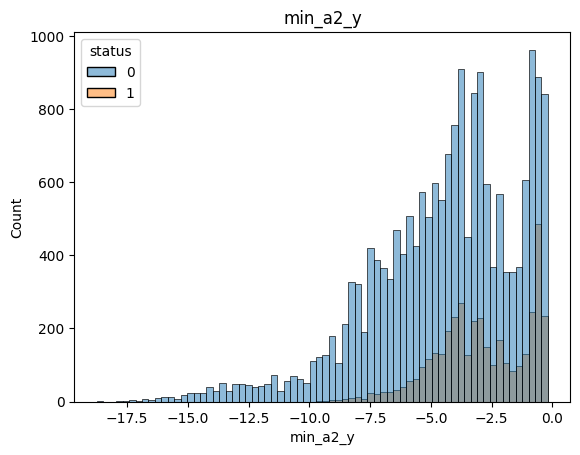

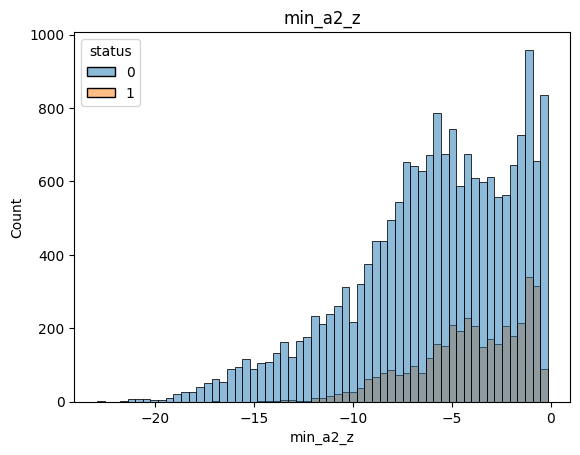

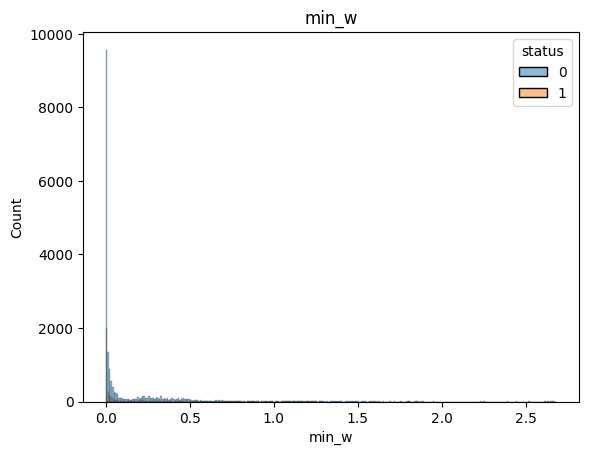

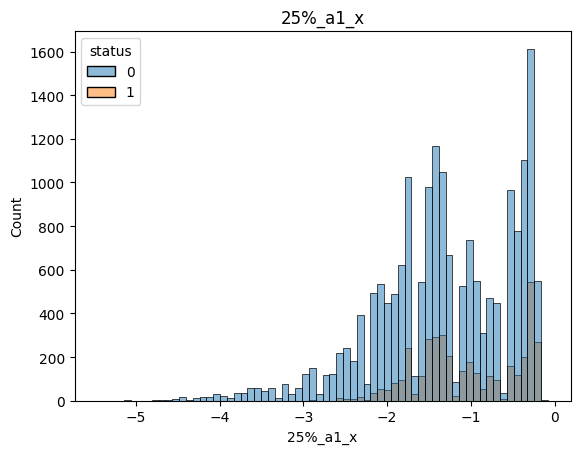

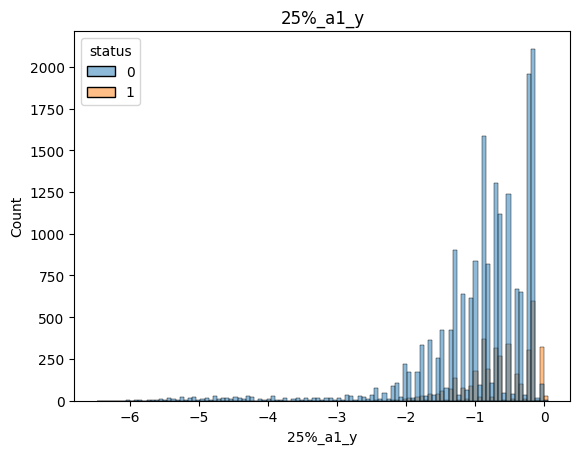

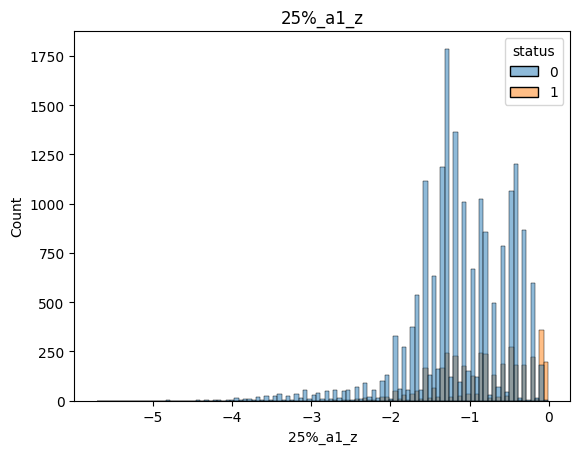

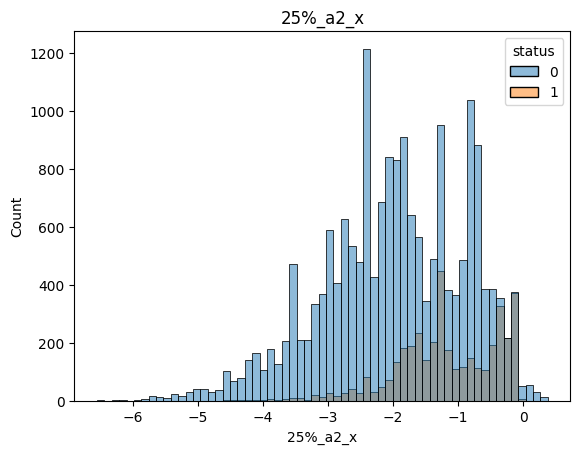

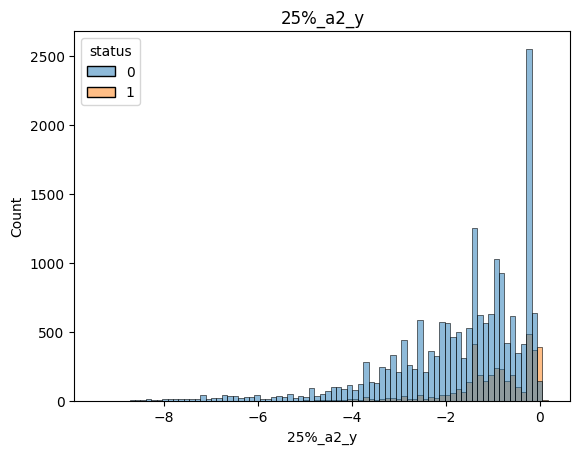

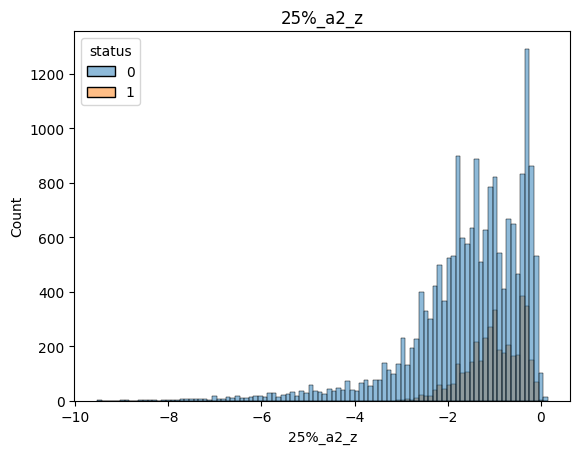

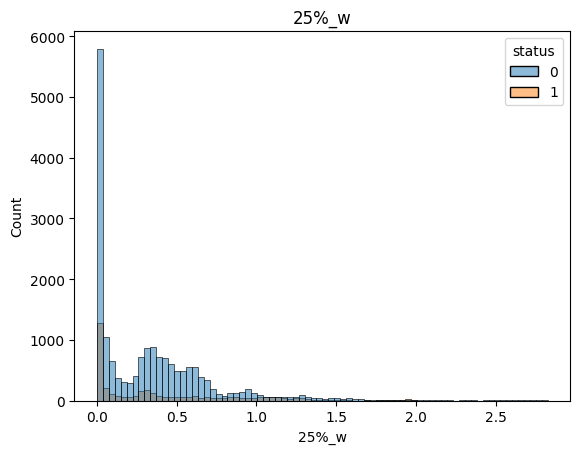

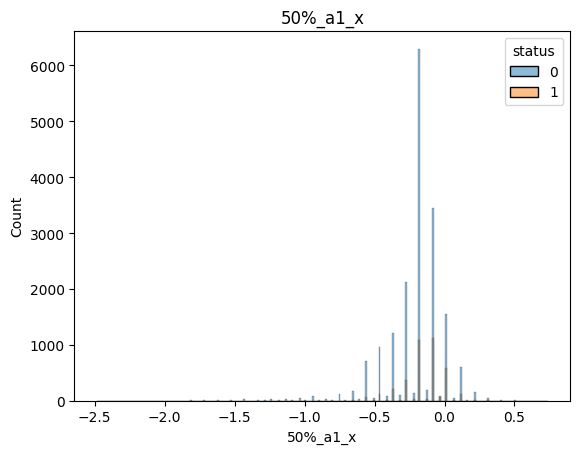

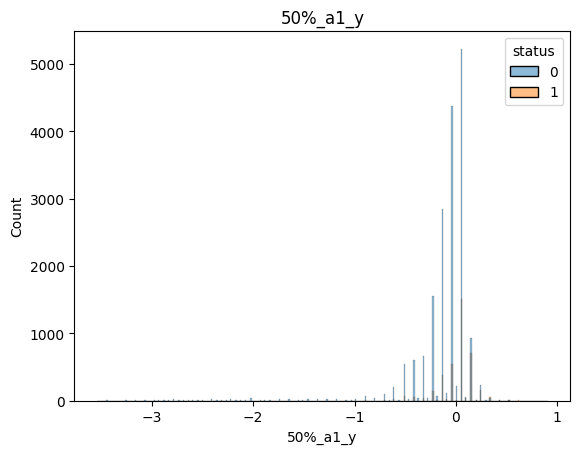

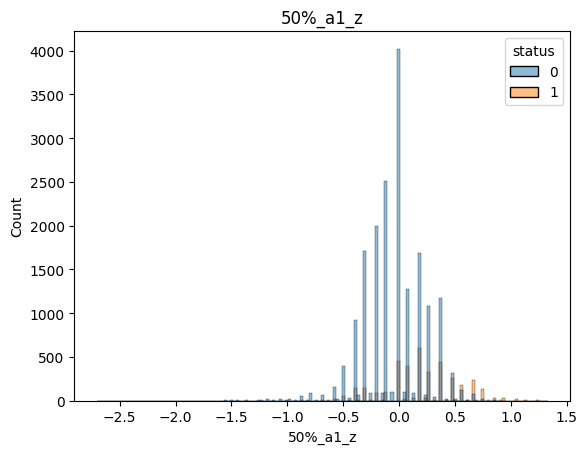

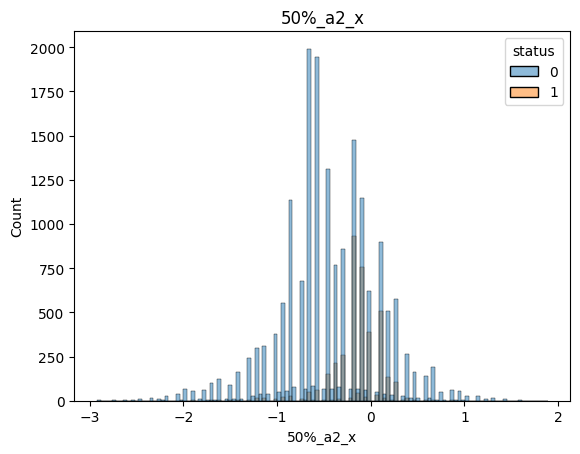

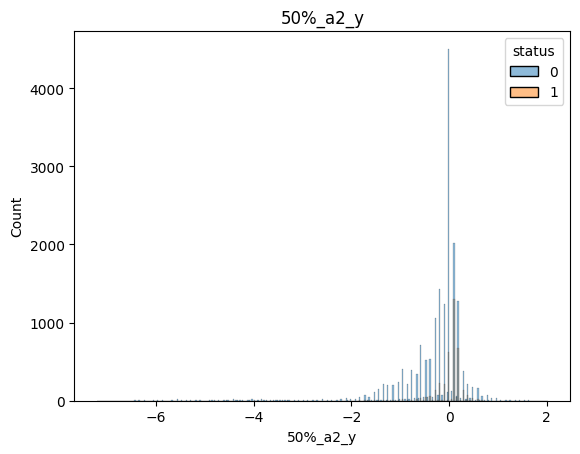

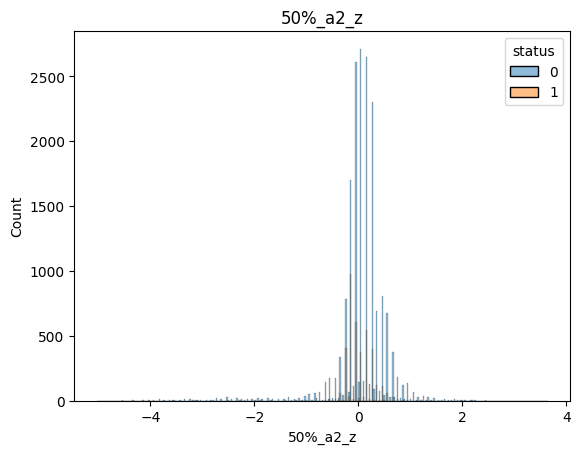

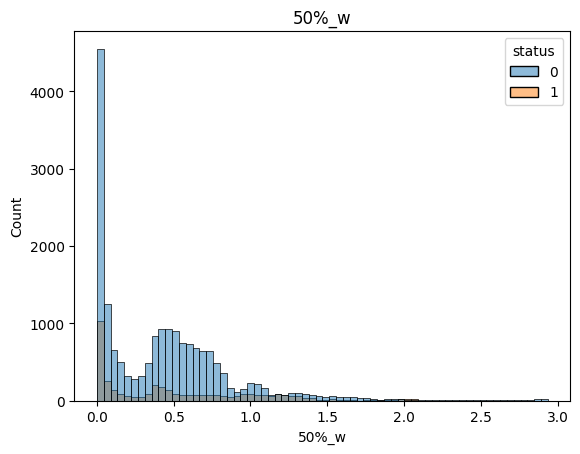

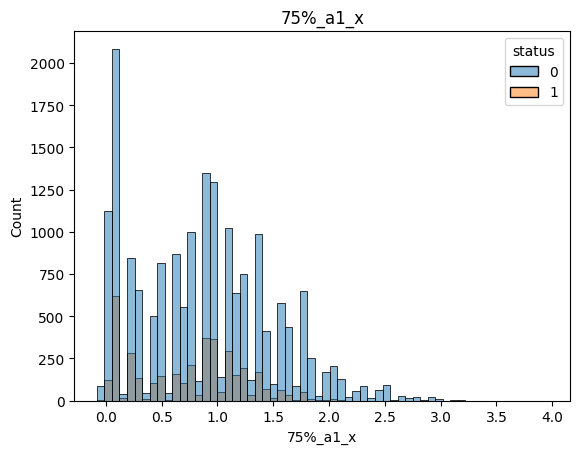

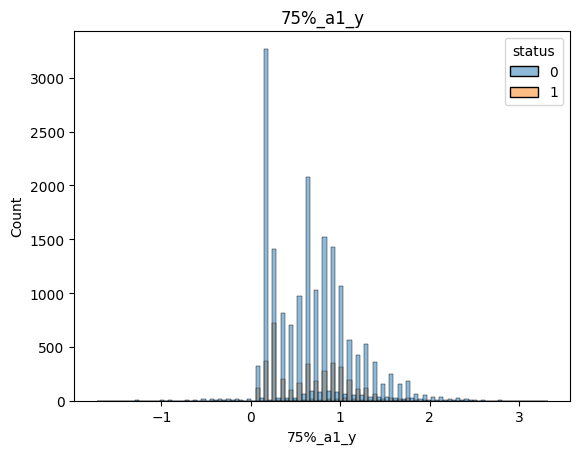

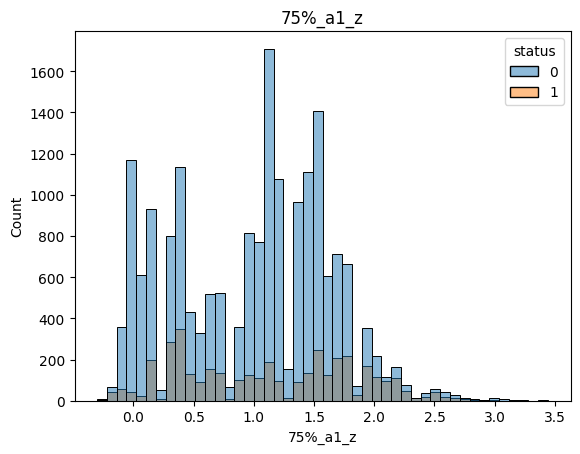

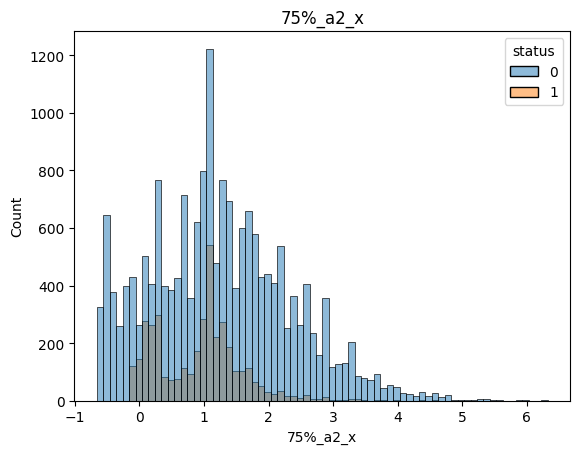

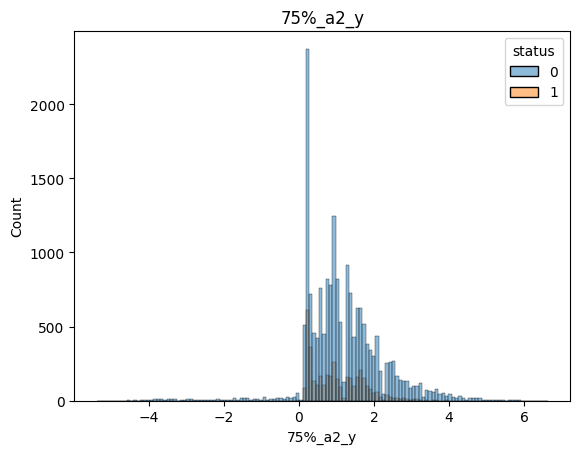

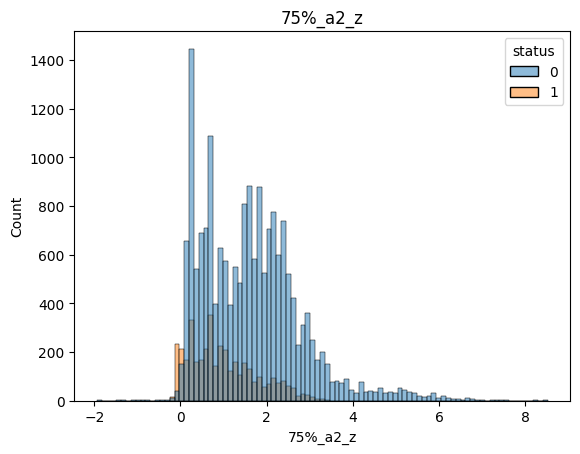

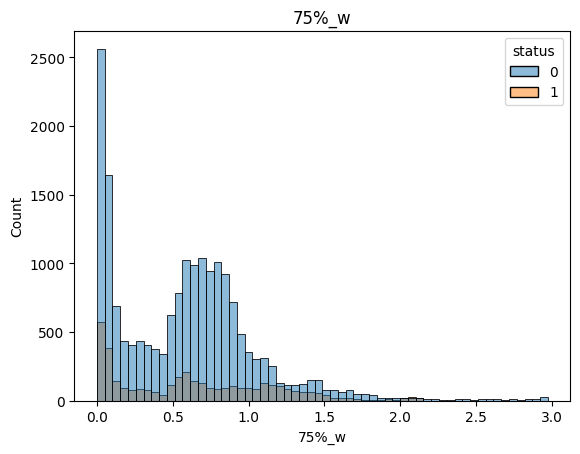

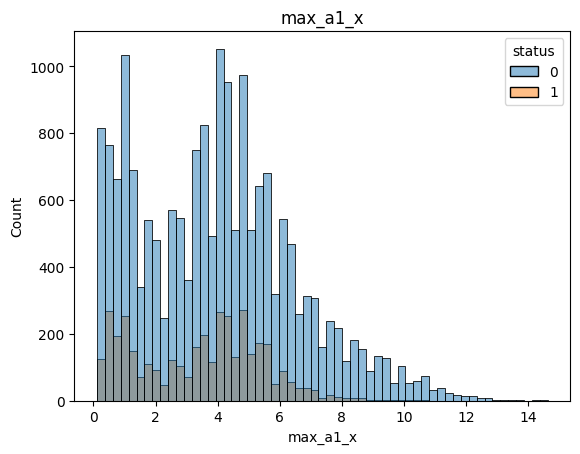

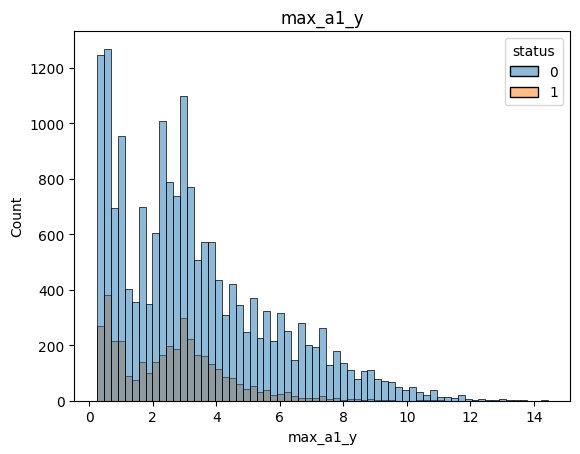

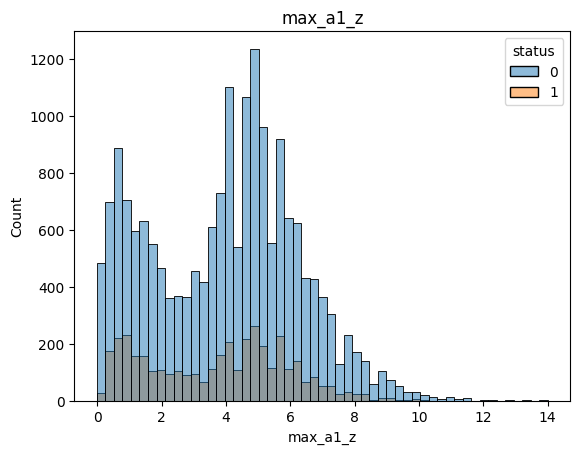

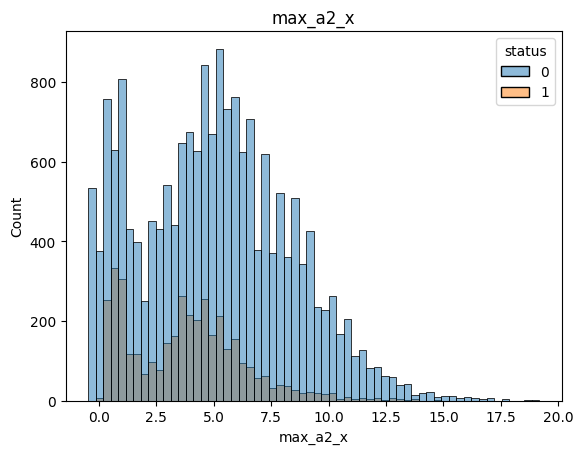

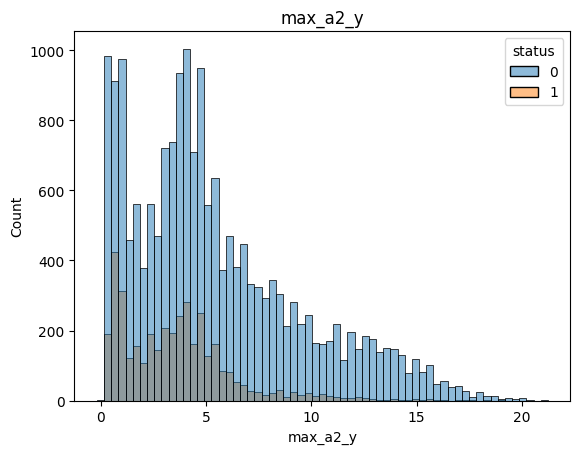

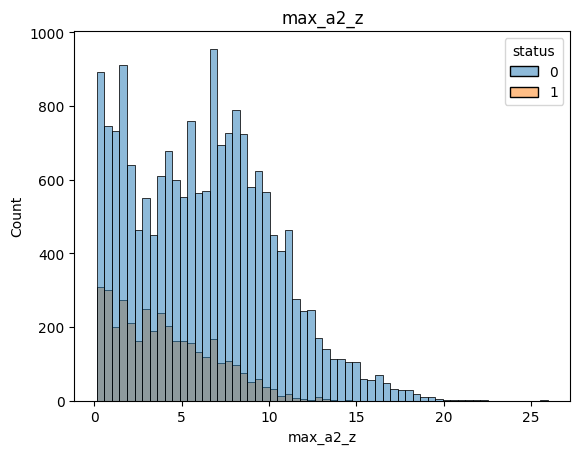

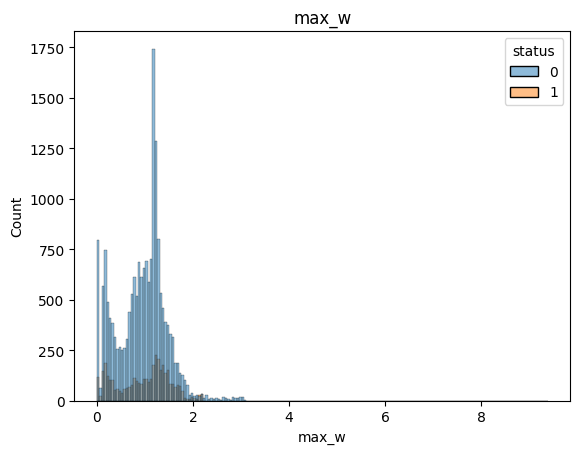

In [21]:
for col in [col for col in result_df.columns[2:-1] if 'rpm' not in col and 'hz' not in col]:
    sns.histplot(
        data = result_df,
        x = col,
        hue="status"
    )
    plt.title(col)
    plt.show()

- 각 컬럼별 status 값의 차이에 따른 유의미한 특징은 보이지 않습니다.

### 1.2 SMOTE를 적용한 ML 모델 성능 테스트
AI 모델 학습 및 테스트 시 활용하기 위해 train_test_split을 이용하여 `result_df`를 `X_train`, `X_test`, `y_train`, `y_test`로 분할합니다.

In [22]:
# 데이터로 쓰일 수 있도록 result_df에서 ["bearing_2_id", "timestamp", "status"] 컬럼을 제외하여 X에 저장합니다.
X = result_df.drop(columns=["bearing_2_id", "timestamp", "status"])

# 라벨로 쓰일 수 있도록 result_df에서 status 컬럼만 y에 저장합니다.
y = result_df.status

# train_test_split을 이용하여 X_train, X_test, y_train, y_test을 저장합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=75)

In [23]:
X_train.shape

(16830, 63)

In [24]:
y_train.shape

(16830,)

In [25]:
X_test.shape

(5611, 63)

In [26]:
X_train.head()

,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_a1_x,...,75%_w,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w
15788,-0.149668,-0.023790,-0.068341,-0.668121,0.012478,0.057708,308.219178,5.136986,0.022101,0.334655,...,0.033661,0.979035,0.528244,0.850044,0.097183,0.578898,3.443675,308.219178,5.136986,0.241261
22436,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,0.015498,0.260193,...,0.017456,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170
11445,-0.267669,0.099550,0.100675,-0.459802,0.131016,0.309480,1484.514293,24.741905,0.423483,2.753910,...,0.566597,7.327991,7.341928,5.363544,8.876783,11.151205,5.835176,1487.603306,24.793388,0.828742
19394,-0.236127,0.038297,0.309182,-0.092888,-0.050812,0.213683,1488.115785,24.801930,0.783609,2.077860,...,0.892235,5.596457,4.124355,4.979416,5.383824,5.865051,6.731989,1500.000000,25.000000,1.157963
13973,-0.302197,0.006969,0.243224,-0.437252,0.030325,0.180521,1490.815738,24.846929,0.478919,1.755781,...,0.643629,5.788850,2.326300,6.611958,3.684547,5.384492,8.724907,1500.000000,25.000000,0.895638


SMOTE를 이용하여 train data를 오버샘플링하여 `X_train_over`,` y_train_over`에 저장합니다.

In [27]:
# SMOTE를 이용하여 오버샘플링합니다.
random_state = 75
X_train_over, y_train_over = SMOTE(random_state=random_state).fit_resample(X_train,y_train)

In [28]:
X_train_over.shape

(27820, 63)

여러가지 모델을 테스트하기 위하여 여러 모델을 선언하여 `models`에 저장합니다.

In [29]:
# models list에 LGBMClassifier, DecisionTreeClassifier, XGBClassifier를 (model_name, model_method) 형태로 맞추어 저장합니다.
# model_method 호출 시 random_state parameter를 위에서 선언한 random_state로 설정합니다.
models = [
    ("lgbm", LGBMClassifier(random_state=random_state)),
    ("xgb", XGBClassifier(random_state=random_state)),
    ("tree", DecisionTreeClassifier(random_state=random_state))
]

SMOTE 적용 전의 모델별 성능을 출력합니다.

In [30]:
def ml_performance_printer(model_name, y_test, y_pred):
    # 예측된 값인 y_pred와 실제 값인 y_test를 이용하여 accuracy, f1_score recall, precision을 산출합니다.
    # f1_score 산출 시 average parameter를 macro로 설정합니다.
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"{model_name}", end="\t")
    print(f"accuracy: {accuracy:.4f}", end="    ")
    print(f"f1_score: {f1:.4f}", end="    ")
    print(f"recall: {recall:.4f}", end="    ")
    print(f"precision: {precision:.4f}")

In [31]:
print("SMOTE 적용 전 ML model 성능 테스트")
trained_model = []

for i, m in enumerate(models):
    model_name, model = m

    # X_train과 y_train을 이용하여 model을 학습합니다.
    model.fit(X_train, y_train)

    # 학습된 모델을 (model_name, model) 형태로 trained_model에 append 합니다.
    trained_model.append((model_name, model))

    # 학습된 모델에 test data를 넣어 예측된 값을 y_pred에 저장합니다.
    y_pred = model.predict(X_test)

    # ml_performance_printer를 이용하여 모델의 성능을 평가합니다.
    ml_performance_printer(model_name, y_test, y_pred)


SMOTE 적용 전 ML model 성능 테스트
[LightGBM] [Info] Number of positive: 2920, number of negative: 13910
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12612
[LightGBM] [Info] Number of data points in the train set: 16830, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173500 -> initscore=-1.561024
[LightGBM] [Info] Start training from score -1.561024
lgbm	accuracy: 0.9886    f1_score: 0.9795    recall: 0.9587    precision: 0.9731
xgb	accuracy: 0.9907    f1_score: 0.9834    recall: 0.9672    precision: 0.9775
tree	accuracy: 0.9638    f1_score: 0.9357    recall: 0.8984    precision: 0.8881


여러가지 모델을 테스트하기 위하여 여러 모델을 선언하여 `models`에 저장합니다.

In [32]:
models = [
    ("lgbm", LGBMClassifier(random_state=random_state)),
    ("xgb", XGBClassifier(random_state=random_state)),
    ("tree", DecisionTreeClassifier(random_state=random_state))
]

SMOTE 적용 후의 모델별 성능을 출력합니다.

In [33]:
print("SMOTE 적용 후 ML model 성능 테스트")
trained_model_over = []
for i, m in enumerate(models):
    model_name, model = m
    # X_train_over와 y_train_over를 이용하여 model을 학습합니다.
    model.fit(X_train_over, y_train_over)
    # 학습된 모델을 (model_name, model) 형태로 trained_model에 append 합니다.
    trained_model_over.append((model_name, model))

    # 학습된 모델에 test data를 넣어 예측된 값을 y_pred에 저장합니다.
    y_pred = model.predict(X_test)

    # ml_performance_printer를 이용하여 모델의 성능을 평가합니다.
    ml_performance_printer(model_name, y_test, y_pred)

SMOTE 적용 후 ML model 성능 테스트
[LightGBM] [Info] Number of positive: 13910, number of negative: 13910
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16063
[LightGBM] [Info] Number of data points in the train set: 27820, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
lgbm	accuracy: 0.9857    f1_score: 0.9747    recall: 0.9640    precision: 0.9519
xgb	accuracy: 0.9898    f1_score: 0.9818    recall: 0.9672    precision: 0.9723
tree	accuracy: 0.9453    f1_score: 0.9068    recall: 0.8984    precision: 0.8009


- SMOTE 적용 후 성능이 더 저하된 것을 확인할 수 있습니다.

- oversampling을 적용할 때 모델 성능이 저하되는 이유는 다음과 같은 요인들이 있을 수 있습니다

- Oversampling을 적용할 때, 주로 데이터를 복제하거나 합성하는 방법을 사용합니다. 이러한 방법은 모델이 훈련 데이터를 더 자세하게 학습할 수 있도록 도와줍니다. 그러나 모델에 적합하지 않은 합성된 데이터가 추가될 수도 있으며, 이는 모델 성능을 저하시킬 수 있습니다.

- Oversampling은 소수 클래스의 샘플을 증가시키는 것이므로, 훈련 데이터가 중복되어 학습될 가능성이 높아집니다. 이는 모델이 훈련 데이터에 과적합되어 실제 데이터에 대한 일반화 성능이 저하될 수 있습니다.

- Oversampling은 소수 클래스에 대한 예측을 더 정확하게 만들 수 있지만, 다수 클래스에 대한 예측의 신뢰도를 감소시킬 수 있습니다. Oversampling으로 생성된 샘플은 기존 데이터와 유사하지만 완전히 동일하지는 않으며, 이로 인해 모델은 다수 클래스의 패턴을 부분적으로 알게 됩니다.

이번엔 train data를 다운 샘플링 하기 위해 기존의 `X_train`, `y_train`을 하나의 DataFrame으로 만듭니다.

In [34]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df

,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_a1_x,...,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w,status
15788,-0.149668,-0.023790,-0.068341,-0.668121,0.012478,0.057708,308.219178,5.136986,0.022101,0.334655,...,0.979035,0.528244,0.850044,0.097183,0.578898,3.443675,308.219178,5.136986,0.241261,0
22436,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,0.015498,0.260193,...,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170,1
11445,-0.267669,0.099550,0.100675,-0.459802,0.131016,0.309480,1484.514293,24.741905,0.423483,2.753910,...,7.327991,7.341928,5.363544,8.876783,11.151205,5.835176,1487.603306,24.793388,0.828742,0
19394,-0.236127,0.038297,0.309182,-0.092888,-0.050812,0.213683,1488.115785,24.801930,0.783609,2.077860,...,5.596457,4.124355,4.979416,5.383824,5.865051,6.731989,1500.000000,25.000000,1.157963,1
13973,-0.302197,0.006969,0.243224,-0.437252,0.030325,0.180521,1490.815738,24.846929,0.478919,1.755781,...,5.788850,2.326300,6.611958,3.684547,5.384492,8.724907,1500.000000,25.000000,0.895638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,-0.184940,-0.019689,-0.153169,-0.669694,-0.074343,0.175623,279.937792,4.665630,0.026165,1.011993,...,2.806765,4.597528,3.442905,4.439781,1.828352,9.123490,279.937792,4.665630,0.192168,0
14472,-0.151032,0.005711,0.109545,-0.614142,0.105363,0.035853,1260.426030,21.007100,0.628059,1.120385,...,2.518176,2.420934,4.595288,3.684547,3.654478,9.023844,1267.605634,21.126761,1.376787,0
21969,-0.155825,0.147191,0.313733,-0.165330,0.191896,0.048101,1496.005052,24.933418,0.394923,1.742620,...,4.634494,3.272645,5.555607,4.439781,3.846702,4.938363,1500.000000,25.000000,0.802710,1
2067,-0.232207,-0.028873,0.006495,-0.066848,0.096422,0.147416,1237.283374,20.621390,0.617041,1.839562,...,4.057317,2.988741,7.092118,6.233463,6.249499,4.639426,1241.379310,20.689655,1.368345,0


In [35]:
train_df.shape

(16830, 64)

`train_df`의 status 컬럼 값의 비율을 확인합니다.

In [36]:
train_df.status.value_counts()

0    13910
1     2920
Name: status, dtype: int64

status 컬럼의 값이 1인 경우가 더 적으므로 status 값이 0인 row를 2,920개만 남겨놓은 `under_df`를 만듭니다.

In [37]:
under_df = pd.concat([
    train_df.query("status == 0").sample(n=len(train_df.query("status == 1"))),
    train_df.query("status == 1")
    ])
under_df

,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_a1_x,...,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w,status
14651,-0.153765,0.011711,0.143776,-0.575013,0.011227,0.036386,691.942279,11.532371,0.101360,0.619726,...,1.556213,1.001417,2.290523,1.135631,1.251681,2.447216,697.674419,11.627907,0.522730,0
11142,-0.327764,0.169513,-0.052209,-0.703528,0.167309,0.004072,1489.829323,24.830489,0.613012,2.761538,...,6.750813,9.707790,5.651639,8.121549,15.956799,7.529156,1500.000000,25.000000,1.212878,0
10650,-0.121949,-0.015354,-0.207583,-0.508761,-0.178822,0.155692,906.997080,15.116618,0.152170,1.442349,...,3.576335,2.420934,2.194491,5.478228,6.633946,3.842259,918.367347,15.306122,0.626403,0
13870,-0.169529,0.000633,0.028152,-0.225812,0.041443,0.046051,960.676542,16.011276,0.346443,1.048503,...,2.421980,1.758493,3.250842,2.457291,2.020576,4.639426,978.260870,16.304348,1.301743,0
5038,-0.092912,-0.005810,-0.245680,-0.001941,0.035865,-0.121986,296.414661,4.940244,0.055919,0.282620,...,0.979035,0.433610,0.754012,1.041226,0.771121,0.753237,305.602716,5.093379,0.409771,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.027326,0.025004,0.004064,-0.071418,-0.027025,-0.114249,149.625939,2.493766,0.230102,0.292666,...,0.690446,0.528244,0.754012,0.852418,0.675009,1.052174,149.625939,2.493766,1.150222,1
22238,-0.226797,0.016458,0.396542,-0.223286,0.141090,0.516619,1500.000000,25.000000,0.582758,2.395621,...,6.269831,3.083376,5.747671,4.534185,4.519485,10.319241,1500.000000,25.000000,0.916214,1
22131,-0.093825,0.107577,0.217063,-0.128007,0.130908,0.216605,550.902758,9.181713,0.179068,0.841832,...,2.902961,1.285320,2.290523,3.118121,1.828352,4.240842,576.923077,9.615385,0.944011,1
19490,-0.082331,0.027943,-0.053616,-0.045053,-0.029811,0.020839,329.408731,5.490146,0.045109,0.478810,...,1.363820,1.001417,1.042108,1.985269,1.732240,1.151820,331.491713,5.524862,0.266673,1


`under_df`를 `X_train_under`, `y_train_under`로 쪼개어 줍니다.

In [38]:
X_train_under = under_df.drop(columns=["status"])
y_train_under = under_df.status

In [39]:
y_train_under.value_counts()

0    2920
1    2920
Name: status, dtype: int64

다운 샘플링 적용 후의 모델별 성능을 출력합니다.

In [40]:
print("다운 샘플링 적용 후 ML model 성능 테스트")
trained_model_under = []
for i, m in enumerate(models):
    model_name, model = m
    # X_train_over와 y_train_over를 이용하여 model을 학습합니다.
    model.fit(X_train_under, y_train_under)
    # 학습된 모델을 (model_name, model) 형태로 trained_model에 append 합니다.
    trained_model_under.append((model_name, model))

    # 학습된 모델에 test data를 넣어 예측된 값을 y_pred에 저장합니다.
    y_pred = model.predict(X_test)

    # ml_performance_printer를 이용하여 모델의 성능을 평가합니다.
    ml_performance_printer(model_name, y_test, y_pred)

다운 샘플링 적용 후 ML model 성능 테스트
[LightGBM] [Info] Number of positive: 2920, number of negative: 2920
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11743
[LightGBM] [Info] Number of data points in the train set: 5840, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
lgbm	accuracy: 0.9758    f1_score: 0.9586    recall: 0.9841    precision: 0.8849
xgb	accuracy: 0.9791    f1_score: 0.9641    recall: 0.9841    precision: 0.9012
tree	accuracy: 0.9312    f1_score: 0.8896    recall: 0.9418    precision: 0.7289


**ML 모델별 성능 정리**

|data |model |accuracy | f1_score | recall | precision |
|---|---|---|---|---|---|
|원본|lgbm |     0.9881 |            0.9785 |            0.9534    |             0.9751|
|원본|xgb |      **0.9907** |            **0.9834** |      0.9672    |             **0.9775**|
|원본|tree |     0.9638 |            0.9357 |            0.8984    |             0.8881|
|오버 샘플링|lgbm |      0.9857 |            0.9748 |            0.9693    |         0.9473|
|오버 샘플링|xgb |   0.9893 |            0.9809 |            0.9672    |             0.9692|
|오버 샘플링|tree |      0.9453 |            0.9068 |            0.8984    |          0.8009|
|다운 샘플링|lgbm |      0.9816 |            0.9684 |            **0.9905**    |       0.9087|
|다운 샘플링|xgb |   0.9815 |            0.9679 |            0.9852    |             0.9119|
|다운 샘플링|tree |      0.9298 |            0.8863 |            0.9249    |          0.7302|

- [원본, xgb]:  f1_score의 성능도 가장 높으며 recall과 precision의 밸런스도 좋습니다.

- [다운 샘플링, lgbm]:  recall의 성능이 가장 높으나 precision이 recall에 비해 성능이 매우 낮습니다.
    - 이는 status가 1인 값들은 잘 예측하면서 0인 값들에 대한 예측 성능이 비교적 낮은 것입니다.
    - 1인 경우를 굉장히 엄격하게 식별해야 한다면 [다운 샘플링, lgbm]이 가장 좋은 모델이 될 수 있습니다.
    - 다른 예시로는 암 환자를 최대한 정확히 식별해야하는 경우에 이러한 모델을 최우선적으로 선택할 수 있습니다. 
    - 암 음성인 환자를 양성으로 판단하여 환자와 의사의 수고로움이 더 많아지겠지만 1명의 암환자라도 놓치지 않는 것이 중요하기 때문입니다.

## 2. DL을 이용한 기계설비 이상 진단 여부 예측 모델 정확도 향상 과정 실습

---

### 2.1 DL 모델 적용을 위한 데이터 전처리
피봇테이블 형식의 데이터에 슬라이딩 윈도우를 적용하여 시계열 데이터로 변환

In [41]:
def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        # Create a rightmost vector as [0, V, 2V, ...].
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    return array[sub_windows]

슬라이딩 윈도우를 적용한 데이터셋을 만듭니다.

In [42]:
# clearing_time_index=9, sub_window_size=10, stride_size=1을 선언합니다.
clearing_time_index = 9
sub_window_size = 10
stride_size = 1

# keys, te_data를 list로 선언합니다.
keys = []
ts_data = []

# for를 이용하여 signals_df.bearing_2_id의 unique 한 값들을 id에 담습니다.
for id in signals_df.bearing_2_id.unique():
    # result_df에서 bearing_2_id가 id와 일치하는 DataFrame만 df에 저장합니다.
    df = result_df[result_df.bearing_2_id==id]
    # df의 길이 - (sub_window_size + stride_size)를 max_time에 저장합니다.
    max_time = len(df) - (sub_window_size + stride_size)
    # df.iloc[:, 2:].values, clearing_time_index, max_time, sub_window_size, stride_size를 
    # vectorized_stride_v2에 넘겨주어 반환 된 값을 ts_data에 append 합니다.
    ts_data.append(vectorized_stride_v2(df.iloc[:, 2:].values, clearing_time_index, max_time, sub_window_size, stride_size))
    # keys에 [id] * len(ts_data[-1]) 를 append 합니다.
    keys.append([id] * len(ts_data[-1]))

`ts_data`를 concatenate하여 완전한 timeseries 형태로 변환합니다.

In [43]:
ts_data = np.concatenate(ts_data)
ts_data.shape

(21721, 10, 64)

ts_data와 매칭돠는 `key_label_df` 구현합니다.

In [44]:
keys_df = pd.DataFrame(reduce(add ,keys), columns=["bearing_2_id"])

# keys_df와 classes_df를 이용하여 ts_data와 매칭되는 bearing_2_id, status 컬럼을 가진 DataFrame을 key_label_df에 저장합니다.
key_label_df = keys_df.merge(classes_df, left_on="bearing_2_id", right_on="bearing_id", how="left").drop(columns=["bearing_id"])
key_label_df

,bearing_2_id,status
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
21716,72,1
21717,72,1
21718,72,1
21719,72,1


데이터 셋을 분할합니다.   
데이터 길이 중 70%에 해당하는 수를 `train_szie`에 저장합니다.

In [45]:
# train으로 사용 할 size를 지정합니다.
train_size = int(len(ts_data)*0.7)

`ts_data`의 length 만큼의 np.arange를 `idx`에 저장 후 shuffle 합니다.

In [46]:
# ts_data의 lenth 만큼의 np.arange를 idx에 저장합니다.
idx = np.arange(len(ts_data))
# idx를 random하게 shuffle합니다. 
np.random.shuffle(idx)

`idx`와 `train_size`를 이용하여 train, test로 쓰일 `idx`를 나누어 각각 `train_idx`, `test_idx`에 저장합니다.

In [47]:
train_idx = idx[:train_size]
test_idx = idx[train_size:]

`ts_data`, `key_label_df`, `train_idx`, `test_idx`를 이용하여 `X_train`, `X_test`, `y_train`, `Y_test`를 만듭니다.

In [48]:
X_train = ts_data[train_idx]
X_test = ts_data[test_idx]
y_train = key_label_df.status.values[train_idx]
y_test = key_label_df.status.values[test_idx]

X_train.shape

(15204, 10, 64)

### 2.2 DL 모델 성능 테스트

모델 성능 평가 시 사용 할 metric을 구현 합니다.   
f1_score 계산 시 필요한 recall을 구현합니다.

In [49]:
def recall(y_true, y_pred):
    # 실제 양성 샘플 중에서 모델이 정확하게 예측한 샘플 수
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    # 실제 양성 샘플 수
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    # 재현율 계산
    return true_positives / (possible_positives + backend.epsilon())


- 정밀도(precision)를 계산할 때 분모에는 모델이 양성으로 예측한 샘플 수(predicted_positives)가 들어갑니다. 하지만 만약 모델이 양성으로 예측한 샘플이 없어서 predicted_positives가 0이라면, 0으로 나누는 오류가 발생합니다.
- 이를 방지하기 위해 엡실론 값을 분모에 더해줍니다. 엡실론은 매우 작은 값을 사용하여, 분모가 0이 되는 상황을 피하고 0으로 나누는 오류를 방지합니다. 엡실론을 더하면 정밀도 값이 아주 작게 나올 수 있지만, 이는 0으로 나누는 오류를 피하는 데 도움을 주는 보험 역할을 합니다.

f1_score 계산 시 필요한 precision을 구현합니다.

In [50]:
def precision(y_true, y_pred):
    # 실제 양성 샘플 중에서 모델이 양성으로 예측한 샘플 수
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    # 모델이 양성으로 예측한 샘플 수
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    # 정밀도 계산
    return true_positives / (predicted_positives + backend.epsilon())

f1_score을 구현합니다.

In [51]:
def f1_score(y_true, y_pred):
    # 정밀도 계산
    p = precision(y_true, y_pred)
    # 재현율 계산
    r = recall(y_true, y_pred)
    # F1-score 계산
    return 2 * ((p * r) / (p + r + backend.epsilon()))

model을 build 후 return하는 model_build()를 구현합니다.

In [52]:
def model_build():
    # Sequential을 이용하여 RNN 기반 모델을 구현합니다.
    model = Sequential([
        # layers.Bidirectional에 tf.keras.layers.LSTM를 파라미터로 넘겨 layer를 구성합니다. 이 때 unit의 수는 데이터의 컬럼 수인 64로 지정합니다.
        layers.Bidirectional(tf.keras.layers.LSTM(64)),
        # layers.Dense를 구성합니다. 이 떄 unit 수는 64, activation은 relu로 지정합니다.
        layers.Dense(64, activation="relu"),
        # output layer의 역할인 layers.Dense를 구성합니다. 이 떄 unit 수는 1, activation은 sigmoid로 지정합니다.
        layers.Dense(1, activation="sigmoid")
    ])
    return model

model을 입력받아 compile 후 return 하는 model_complie()을 구현합니다.

In [53]:
def model_complie(model, optimizer=tf.keras.optimizers.Adam, lr=1e-4):
    # model을 compile 합니다.
    model.compile(
        # loss는 tf.keras.losses.BinaryCrossentropy()로 지정합니다.
        loss=tf.keras.losses.BinaryCrossentropy(),
        # optimizer은 tf.keras.optimizers.Adam(1e-4)로 지정합니다.
        optimizer=optimizer(lr),
        # metrics는 accuracy와 위에서 선언한 f1_score, precision, recall로 지정합니다.
        metrics=[f1_score, tf.keras.metrics.AUC(), recall, precision, "accuracy"]
    )
    return model

model을 학습 후 return하는 model_train을 구현합니다.

In [54]:
def model_train(model, X_train, y_train, epochs=30, batch_size=30, callbacks=None):
    hist = model.fit(
        # 학습 데이터를 넣어줍니다.
        X_train,
        # 라벨 데이터를 넣어줍니다.
        y_train,
        # epochs를 50으로 지정합니다.
        epochs=epochs,
        # batch_size는 30으로 지정합니다.
        batch_size=batch_size,
        # callbacks으로 callbacks.EarlyStopping을 선언합니다.
        callbacks = callbacks
    )
    return hist, model



model을 입력받아 성능을 평가하는 model_evaluate를 구현합니다.

In [55]:
# def model_evaluate(model, X_test, y_test):
#     loss, f1, auroc, recall, precision, accuracy = model.evaluate(X_test,  y_test)
#     return loss, f1, auroc, recall, precision, accuracy
def model_evaluate(model, X_test, y_test):
    return model.evaluate(X_test,  y_test)

위에서 선언한 함수들을 이용하여 model을 build, compile, train 후 evaluate 합니다.   
for를 이용하여 batch_size 별 성능 테스트를 진행합니다.


optimizer의 변화에 따른 성능을 측정합니다.

**주의!! 5분 걸림**

In [56]:
opt_performance = []
optimizers = [
    tf.keras.optimizers.SGD,
    tf.keras.optimizers.Adagrad,
    tf.keras.optimizers.RMSprop,
    tf.keras.optimizers.Adam,
]
for opt in optimizers:
    # model_build()의 return 값을 model에 저장합니다.
    model = model_build()
    # model_complie()을 사용하여 model을 compile하여 model에 저장합니다.
    model = model_complie(model, optimizer=opt)
    # model_train()을 사용하여 model을 학습합니다.
    hist, model = model_train(model, X_train, y_train, epochs=30, batch_size=220, 
        callbacks = [callbacks.EarlyStopping(
            # early stopping의 기준을 f1_score로 지정합니다.
            monitor="f1_score",
            mode="max",
            patience = 5
        )])
    opt_performance.append([opt.__name__] + list(model_evaluate(model, X_test, y_test)))

2023-08-23 08:52:03.014882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-23 08:52:03.014918: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-23 08:52:03.014947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0c5340f55ee3): /proc/driver/nvidia/version does not exist
2023-08-23 08:52:03.015592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

Epoch 1/30
70/70 [==============================] - 4s 14ms/step - loss: 0.7209 - f1_score: 0.2621 - auc: 0.5023 - recall: 0.8497 - precision: 0.1669 - accuracy: 0.2658
Epoch 2/30
70/70 [==============================] - 1s 14ms/step - loss: 0.6587 - f1_score: 0.0473 - auc: 0.4980 - recall: 0.0296 - precision: 0.1290 - accuracy: 0.7959
Epoch 3/30
70/70 [==============================] - 1s 14ms/step - loss: 0.6167 - f1_score: 0.0378 - auc: 0.4953 - recall: 0.0237 - precision: 0.1049 - accuracy: 0.7989
Epoch 4/30
70/70 [==============================] - 1s 15ms/step - loss: 0.5650 - f1_score: 0.0360 - auc: 0.4985 - recall: 0.0215 - precision: 0.1200 - accuracy: 0.8014
Epoch 5/30
70/70 [==============================] - 1s 14ms/step - loss: 0.5560 - f1_score: 0.0341 - auc: 0.4796 - recall: 0.0207 - precision: 0.1108 - accuracy: 0.8024
Epoch 6/30
204/204 [==============================] - 1s 3ms/step - loss: 0.5275 - f1_score: 0.0365 - auc: 0.5010 - recall: 0.0243 - precision: 0.0923 - ac

`opt_performance`를 DataFrame로 변환 후 `auroc` 컬럼을 기준으로 내림차순 정렬하여 출력합니다.

In [57]:
pd.DataFrame(
    opt_performance,
    columns=["optimizer", "loss", "f1", "auroc", "recall", "precision", "accuracy"]
).sort_values(by="auroc", ascending=False)

,optimizer,loss,f1,auroc,recall,precision,accuracy
3,Adam,0.099079,0.874219,0.991564,0.863121,0.915498,0.964247
2,RMSprop,0.406330,0.000000,0.819363,0.000000,0.000000,0.831978
1,Adagrad,0.582326,0.023615,0.510547,0.014416,0.071078,0.825994
0,SGD,0.527500,0.036503,0.501000,0.024328,0.092320,0.812797


batch size의 변화에 따른 성능을 측정합니다.

**주의!! 15~20분 걸림**

In [ ]:
bs_performance = []
for bs in range(20, 221, 50):
    # model_build()의 return 값을 model에 저장합니다.
    model = model_build()
    # model_complie()을 사용하여 model을 compile하여 model에 저장합니다.
    model = model_complie(model)
    # model_train()을 사용하여 model을 학습합니다.
    hist, model = model_train(model, X_train, y_train, epochs=30, batch_size=bs, 
        callbacks = [callbacks.EarlyStopping(
            # early stopping의 기준을 f1_score로 지정합니다.
            monitor="f1_score",
            mode="max",
            patience = 5
        )])
    bs_performance.append([bs] + list(model_evaluate(model, X_test, y_test)))

Epoch 1/30
761/761 [==============================] - 113s 144ms/step - loss: 0.4668 - f1_score: 0.0052 - auc_4: 0.5621 - recall: 0.0131 - precision: 0.0042 - accuracy: 0.8191
Epoch 2/30
761/761 [==============================] - 108s 142ms/step - loss: 0.4254 - f1_score: 0.0134 - auc_4: 0.7423 - recall: 0.0095 - precision: 0.0276 - accuracy: 0.8272
Epoch 3/30
761/761 [==============================] - 120s 158ms/step - loss: 0.3792 - f1_score: 0.0473 - auc_4: 0.8143 - recall: 0.0347 - precision: 0.0961 - accuracy: 0.8308
Epoch 4/30
761/761 [==============================] - 131s 172ms/step - loss: 0.3420 - f1_score: 0.2196 - auc_4: 0.8520 - recall: 0.1823 - precision: 0.3609 - accuracy: 0.8473
Epoch 5/30
761/761 [==============================] - 139s 183ms/step - loss: 0.3061 - f1_score: 0.4246 - auc_4: 0.8828 - recall: 0.3679 - precision: 0.6062 - accuracy: 0.8753
Epoch 6/30
761/761 [==============================] - 128s 168ms/step - loss: 0.2709 - f1_score: 0.5598 - auc_4: 0.9077 

`bs_performance`를 DataFrame로 변환 후 `auroc` 컬럼을 기준으로 내림차순 정렬하여 출력합니다.

batch size에 따른 성능변화를 확인할 수 있습니다.
또한 학습 시 epoch를 자세히 살펴보면 제대로 학습이 되기 전에 멈추어버리는 것을 확인할 수 있습니다. 이는 early stopping의 patience가 너무 낮은 값인 5로 설정되어 학습이 일찍 끝나버리는 것입니다. 이러한 점들을 유의하여 학습을 진행하도록 합니다.

In [ ]:
pd.DataFrame(
    bs_performance,
    columns=["batch_size", "loss", "f1", "auroc", "recall", "precision", "accuracy"]
).sort_values(by="auroc", ascending=False)

learning rate의 변화에 따른 성능을 측정합니다.

**주의!! 20분 걸림**

In [ ]:
lr_performance = []
for lr in [0.1, 0.01, 0.001, 0.0001]:
    # model_build()의 return 값을 model에 저장합니다.
    model = model_build()
    # model_complie()을 사용하여 model을 compile하여 model에 저장합니다.
    model = model_complie(model, lr=lr)
    # model_train()을 사용하여 model을 학습합니다.
    hist, model = model_train(model, X_train, y_train, epochs=30, batch_size=20, 
        callbacks = [callbacks.EarlyStopping(
            # early stopping의 기준을 f1_score로 지정합니다.
            monitor="f1_score",
            mode="max",
            patience = 5
        )])
    lr_performance.append([str(lr)] + list(model_evaluate(model, X_test, y_test)))

`lr_performance`를 DataFrame로 변환 후 `auroc` 컬럼을 기준으로 내림차순 정렬하여 출력합니다.

lr이 0.1인 경우 optimizer가 최적의 값을 찾기에는 너무 큰 값이었기에 학습이 일찍 끝나 학습이 제대로 이루어지지 않았습니다.

In [ ]:
pd.DataFrame(
    lr_performance,
    columns=["lr", "loss", "f1", "auroc", "recall", "precision", "accuracy"]
).sort_values(by="auroc", ascending=False)